In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston-housing-dataset/BostonHousing.csv


In [31]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
import lightgbm as lgb
import shap

In [32]:
df = pd.read_csv("/kaggle/input/boston-housing-dataset/BostonHousing.csv")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(df.shape)
df.head()

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,501.0,6.284341,0.705587,3.56100,5.884000,6.20800,6.625000,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [34]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         5
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [35]:
df.dropna(inplace=True)
f"NB NULL = {df.isna().sum().sum()}"

'NB NULL = 0'

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     501 non-null    float64
 1   zn       501 non-null    float64
 2   indus    501 non-null    float64
 3   chas     501 non-null    int64  
 4   nox      501 non-null    float64
 5   rm       501 non-null    float64
 6   age      501 non-null    float64
 7   dis      501 non-null    float64
 8   rad      501 non-null    int64  
 9   tax      501 non-null    int64  
 10  ptratio  501 non-null    float64
 11  b        501 non-null    float64
 12  lstat    501 non-null    float64
 13  medv     501 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 58.7 KB


In [37]:
float_col = df.select_dtypes(include=['float']).columns
float_col

Index(['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'ptratio', 'b',
       'lstat', 'medv'],
      dtype='object')

In [38]:
for col in df.columns:
    if col not in float_col:
        print(f"Val Unique dans col {col} : {df[col].unique()}")

Val Unique dans col chas : [0 1]
Val Unique dans col rad : [ 1  2  3  5  4  8  6  7 24]
Val Unique dans col tax : [296 242 222 311 307 279 252 233 243 469 226 313 256 284 216 337 345 305
 398 281 247 270 276 384 432 188 437 403 193 265 255 329 402 348 224 277
 300 330 315 244 264 223 254 198 285 241 293 245 289 358 304 287 430 422
 370 352 351 280 335 411 187 334 666 711 391 273]


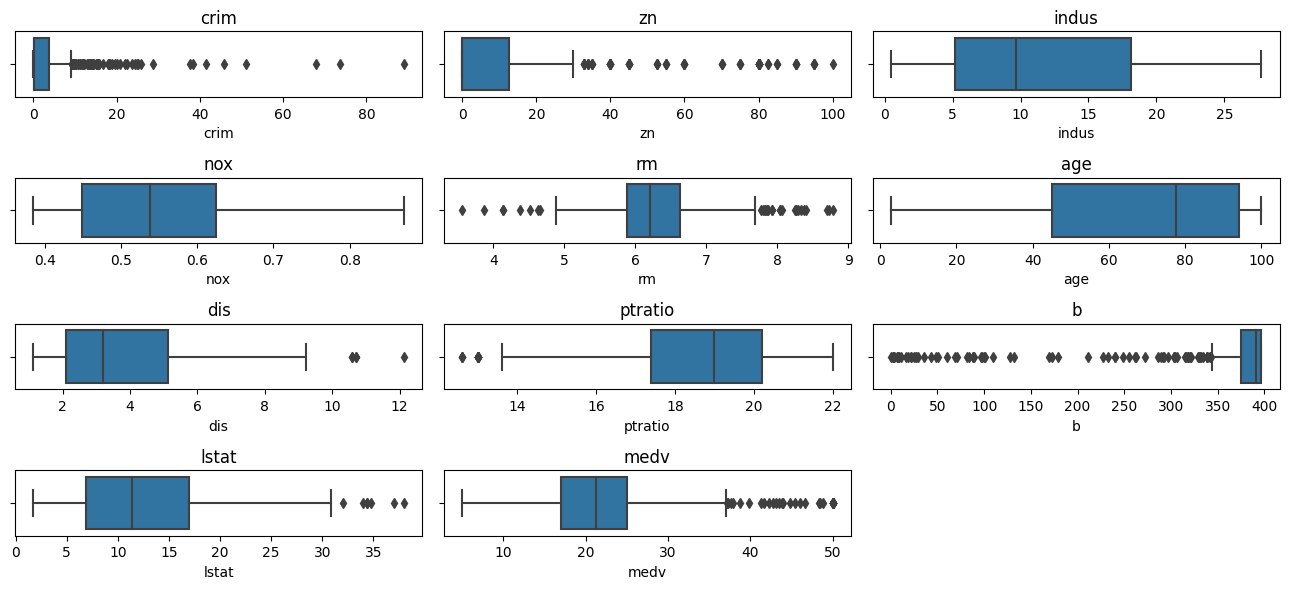

In [39]:
def boxplots(data, r, c):
    plt.figure(figsize=(13,6))
    ind = 1
    for col in data.columns:
        plt.subplot(r, c, ind)
        sns.boxplot(data = data, x=col)
        plt.title(col)
        ind = ind+1
        plt.tight_layout()
    
boxplots(df[float_col], 4, 3)

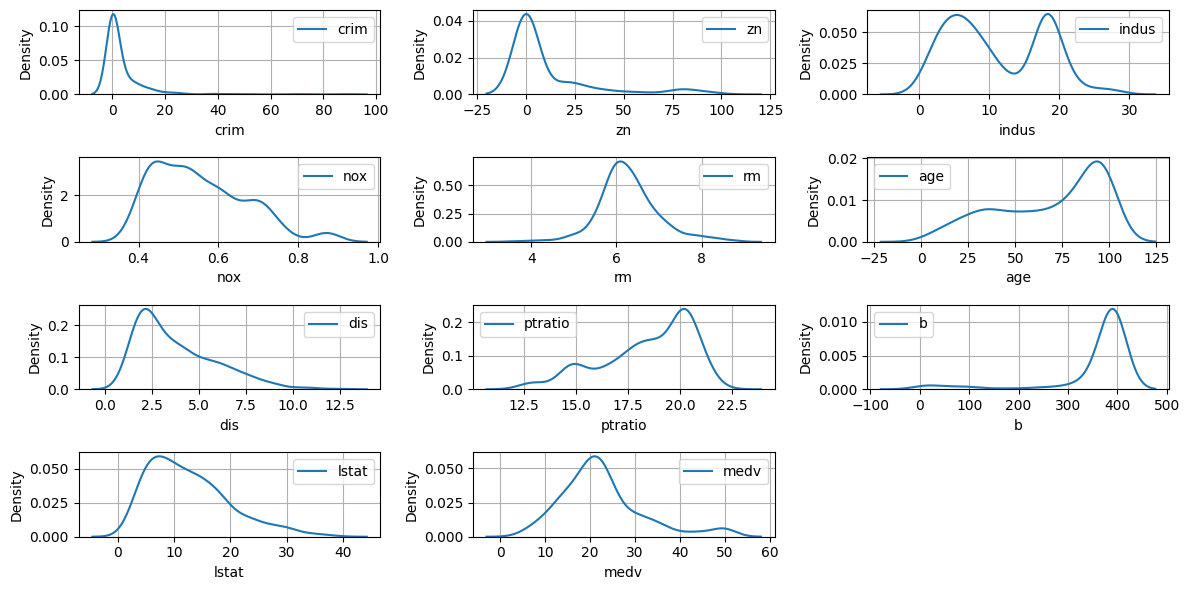

In [40]:
def all_kde(data, r, c):
    """
    montre la distribution de la col
    """
    ind = 1
    plt.figure(figsize=(12,6))
    for col in data.columns:
        plt.subplot(r, c, ind)
        sns.kdeplot(data[col], label=col)
        plt.tight_layout()
        plt.legend()
        plt.grid()
        ind = ind+1

all_kde(df[float_col], 4, 3)

In [41]:
# Z-score quand data suivent une loi normale
# IQR method sinon
skeww = []
normal = []
for col in df[float_col]:
    skw = df[col].skew()
    print(col, skw)
    if skw > -0.5 and skw <0.5:
        normal.append(col)
    else:
        skeww.append(col)

crim 5.198438073065747
zn 2.217016855281167
indus 0.28611302659023
nox 0.7218213838617168
rm 0.4034215968136548
age -0.5967612210326316
dis 1.0194030493767585
ptratio -0.8037051479281515
b -2.8718664654967596
lstat 0.9084868890627005
medv 1.0985356600319445


In [42]:
print(f"N : {normal}\n\nS : {skeww}")

N : ['indus', 'rm']

S : ['crim', 'zn', 'nox', 'age', 'dis', 'ptratio', 'b', 'lstat', 'medv']


In [43]:
#IQR 
for col in skeww:
    q1 = np.quantile(df[col], 0.25)
    q3 = np.quantile(df[col], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print("Started Removing ", col, " Outliers")
    print("No. of Outliers in ", col, " are : ",len(df[(df[col] > upper) | (df[col] < lower)]))
    if len(df[(df[col] > upper) | (df[col] < lower)]) > 0:
        # Cap the outliers
        df[col] = np.where(df[col] > upper, upper,
                      np.where(df[col] < lower, lower, df[col]))

    print("Finished Processing", col)
    print()

Started Removing  crim  Outliers
No. of Outliers in  crim  are :  66
Finished Processing crim

Started Removing  zn  Outliers
No. of Outliers in  zn  are :  68
Finished Processing zn

Started Removing  nox  Outliers
No. of Outliers in  nox  are :  0
Finished Processing nox

Started Removing  age  Outliers
No. of Outliers in  age  are :  0
Finished Processing age

Started Removing  dis  Outliers
No. of Outliers in  dis  are :  5
Finished Processing dis

Started Removing  ptratio  Outliers
No. of Outliers in  ptratio  are :  15
Finished Processing ptratio

Started Removing  b  Outliers
No. of Outliers in  b  are :  76
Finished Processing b

Started Removing  lstat  Outliers
No. of Outliers in  lstat  are :  7
Finished Processing lstat

Started Removing  medv  Outliers
No. of Outliers in  medv  are :  37
Finished Processing medv



In [44]:
# Z-Score
from scipy.stats import zscore

for col in normal:
    print(f"Processing {col}")
    zc = zscore(df[col])

    outliers = np.where(np.abs(zc) > 3)
    print(f"Number of outliers in {col}: {len(outliers[0])}")
    
    # Optionally, remove outliers
    df = df[(np.abs(zc) <= 3)]
    print()


Processing indus
Number of outliers in indus: 0

Processing rm
Number of outliers in rm: 7



In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,494.0,2.208360,3.311210,0.00632,0.080573,0.252775,3.647423,9.10979
zn,494.0,7.016194,12.093753,0.00000,0.000000,0.000000,12.500000,31.25000
indus,494.0,11.114980,6.858753,0.46000,5.190000,9.690000,18.100000,27.74000
chas,494.0,0.068826,0.253414,0.00000,0.000000,0.000000,0.000000,1.00000
nox,494.0,0.553817,0.116189,0.38500,0.448250,0.538000,0.624000,0.87100
rm,494.0,6.288555,0.650144,4.36800,5.887250,6.208500,6.618750,8.39800
age,494.0,68.187247,28.263007,2.90000,43.875000,76.800000,93.900000,100.00000
dis,494.0,3.802740,2.061239,1.12960,2.107650,3.239250,5.213925,9.66270
rad,494.0,9.463563,8.673108,1.00000,4.000000,5.000000,24.000000,24.00000
tax,494.0,407.044534,168.036827,187.00000,279.000000,330.000000,666.000000,711.00000


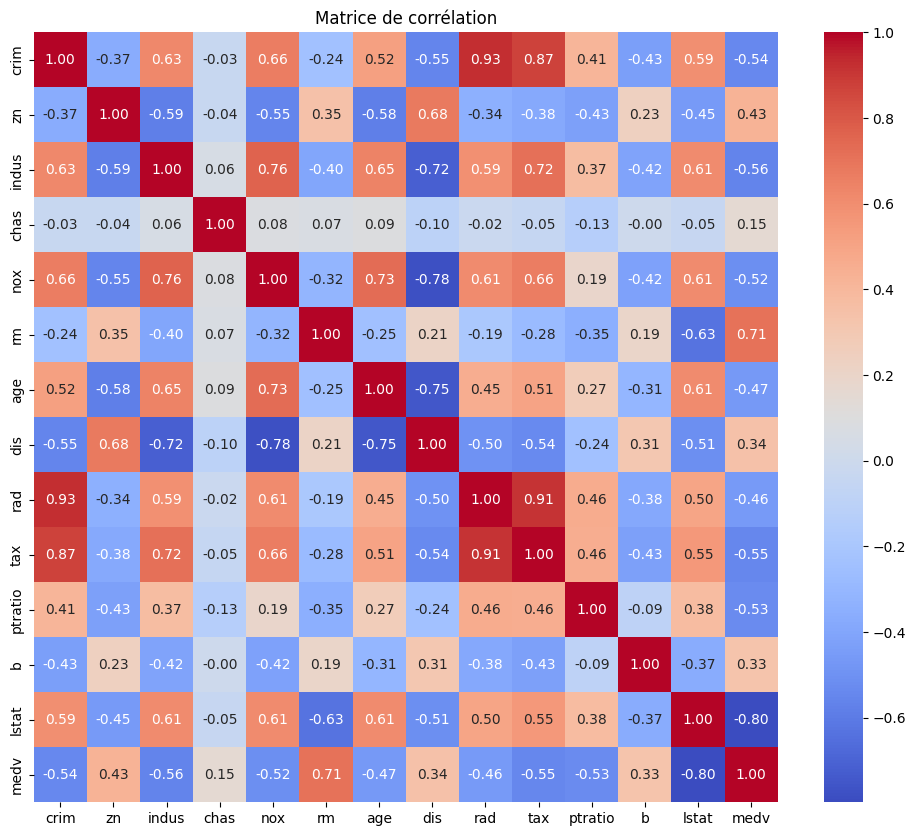

In [46]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

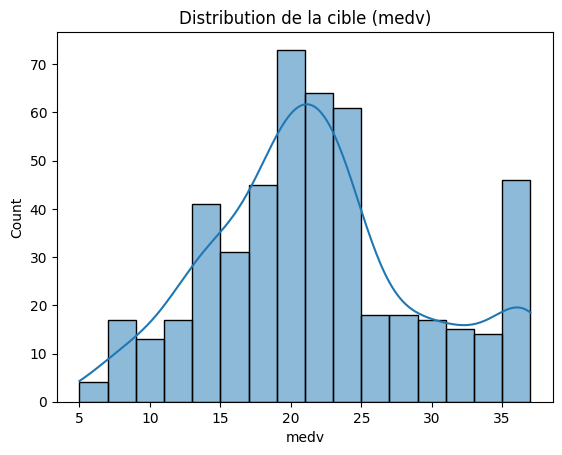

In [47]:
target_col = 'medv'

plt.figure()
sns.histplot(df[target_col], kde=True)
plt.title(f'Distribution de la cible ({target_col})')
plt.show()

In [48]:
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [49]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print('\nNumerical cols:', num_cols)
print('Categorical cols:', cat_cols)


Numerical cols: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
Categorical cols: []


In [50]:
X = df.drop(columns=[target_col])
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('\nSplit fait :', X_train.shape, X_test.shape)


Split fait : (395, 13) (99, 13)


In [51]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

In [52]:
def fit_and_eval(model, X_train, X_test, y_train, y_test, preprocessor=None, use_poly=False):
    steps = []
    steps.append(('preproc', preprocessor))
    if use_poly:
        # ajouter des features polynomiales de degré 2 (interactions)
        steps.append(('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)))
    steps.append(('model', model))
    pipe = Pipeline(steps=steps)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = regression_metrics(y_test, y_pred)
    return pipe, metrics

# Affichage synthétique
def print_metrics(name, metrics):
    print(f"{name} -> RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R2: {metrics['R2']:.4f}")

In [53]:
# ---------- Régression Linéaire (Ridge / Lasso) ----------
ridge = Ridge(random_state=RANDOM_STATE)
lasso = Lasso(random_state=RANDOM_STATE, max_iter=5000)

pipe_ridge, metrics_ridge = fit_and_eval(ridge, X_train, X_test, y_train, y_test, preprocessor)
pipe_lasso, metrics_lasso = fit_and_eval(lasso, X_train, X_test, y_train, y_test, preprocessor)

print_metrics('Ridge', metrics_ridge)
print_metrics('Lasso', metrics_lasso)

Ridge -> RMSE: 2.8381, MAE: 2.2042, R2: 0.8553
Lasso -> RMSE: 3.2784, MAE: 2.6097, R2: 0.8069


In [54]:
# ---------- Random Forest ----------
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
pipe_rf, metrics_rf = fit_and_eval(rf, X_train, X_test, y_train, y_test, preprocessor)
print('\n--- Random Forest ---')
print_metrics('RandomForest', metrics_rf)


--- Random Forest ---
RandomForest -> RMSE: 2.2887, MAE: 1.7386, R2: 0.9059


In [55]:
# ---------- XGBoost ----------
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1)
pipe_xgb, metrics_xgb = fit_and_eval(xgbr, X_train, X_test, y_train, y_test, preprocessor)
print('\n--- XGBoost ---')
print_metrics('XGBoost', metrics_xgb)


--- XGBoost ---
XGBoost -> RMSE: 2.3356, MAE: 1.8124, R2: 0.9020


In [56]:
# ---------- LightGBM ----------
lgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
pipe_lgb, metrics_lgb = fit_and_eval(lgbm, X_train, X_test, y_train, y_test, preprocessor)
print('\n--- LightGBM ---')
print_metrics('LightGBM', metrics_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 13
[LightGBM] [Info] Start training from score 21.905063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [57]:
# ---------- MLP (réseau de neurones simple) ----------
mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=RANDOM_STATE)
pipe_mlp, metrics_mlp = fit_and_eval(mlp, X_train, X_test, y_train, y_test, preprocessor)
print('\n--- MLP ---')
print_metrics('MLP', metrics_mlp)


--- MLP ---
MLP -> RMSE: 2.7554, MAE: 1.9938, R2: 0.8636


In [58]:
# ---------- Stacking ----------
estimators = [
('ridge', Ridge()),
('rf', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)),
]
estimators.append(('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)))

stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(), n_jobs=-1)
pipe_stack, metrics_stack = fit_and_eval(stack, X_train, X_test, y_train, y_test, preprocessor)
print('\n--- Stacking ---')
print_metrics('Stacking', metrics_stack)


--- Stacking ---
Stacking -> RMSE: 2.1553, MAE: 1.6113, R2: 0.9165


In [59]:
# ---------- Hyperparameter tuning (RandomizedSearchCV) ----------
print('\n--- Hyperparameter tuning (exemple pour RandomForest) ---')
param_dist = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [None, 6, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}
rf_pipe = Pipeline(steps=[('preproc', preprocessor), ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
rnd = RandomizedSearchCV(rf_pipe, param_dist, n_iter=8, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rnd.fit(X_train, y_train)
print('Best params:', rnd.best_params_)
best_rf = rnd.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print('Metrics after tuning:', regression_metrics(y_test, y_pred_rf))


--- Hyperparameter tuning (exemple pour RandomForest) ---
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 10}
Metrics after tuning: {'RMSE': 2.312060259039768, 'MAE': 1.7701558338208858, 'R2': 0.9039668269943116}



--- SHAP explanations pour XGBoost (exemple) ---


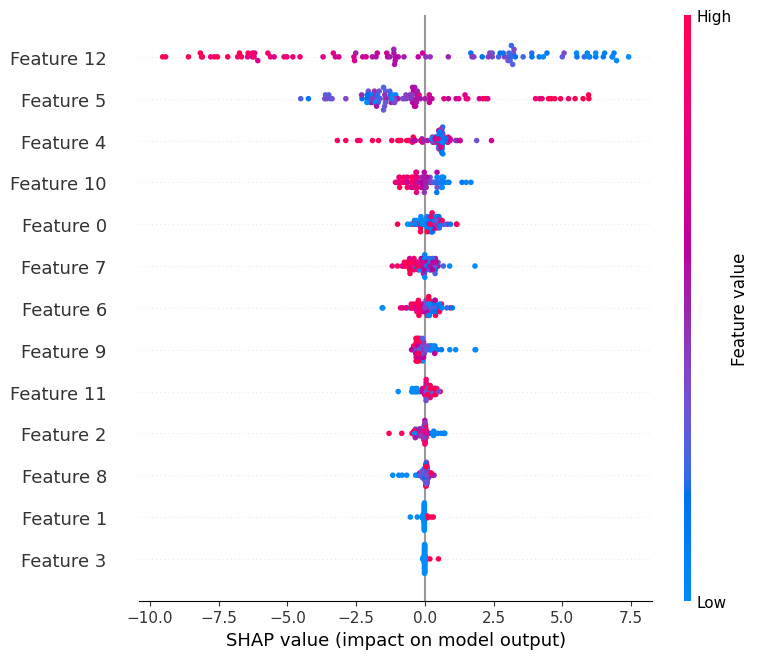

In [60]:
# ---------- Interprétabilité avec SHAP ----------
print('\n--- SHAP explanations pour XGBoost (exemple) ---')
# On prend le modèle XGBoost entraîné plus haut (pipe_xgb)
# Extraire modèle et transformer les données
model = pipe_xgb.named_steps['model'] if 'pipe_xgb' in globals() else None
if model is not None:
    # préparer X_test transformé
    preproc = pipe_xgb.named_steps['preproc']
    X_test_trans = preproc.transform(X_test)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_trans)
    shap.summary_plot(shap_values, X_test_trans)

In [61]:
results = {
    'Ridge': metrics_ridge,
    'Lasso': metrics_lasso,
    'RandomForest': metrics_rf,
}
results['XGBoost'] = metrics_xgb
results['LightGBM'] = metrics_lgb
results['MLP'] = metrics_mlp
results['Stacking'] = metrics_stack
print('\n--- Résultats synthétiques ---')
for k,v in results.items():
    print_metrics(k, v)


--- Résultats synthétiques ---
Ridge -> RMSE: 2.8381, MAE: 2.2042, R2: 0.8553
Lasso -> RMSE: 3.2784, MAE: 2.6097, R2: 0.8069
RandomForest -> RMSE: 2.2887, MAE: 1.7386, R2: 0.9059
XGBoost -> RMSE: 2.3356, MAE: 1.8124, R2: 0.9020
LightGBM -> RMSE: 2.2953, MAE: 1.7618, R2: 0.9054
MLP -> RMSE: 2.7554, MAE: 1.9938, R2: 0.8636
Stacking -> RMSE: 2.1553, MAE: 1.6113, R2: 0.9165
